## Sensitivity 



In [1]:
import itertools
from pathlib import Path
import copy

import numpy as np
import pandas as pd

from scripts.design.plot_design import plot_combined_measure_figure, plot_sensitivity
from scripts.design.utils import get_traject_probs, get_target_beta_grid, get_cost_traject_pf_combinations, \
    get_measures_df_with_dsn, get_dsn_point_pf_cost, get_least_expensive_combination_point, get_vr_eco_optimum_point
from scripts.postprocessing.database_access_functions import get_overview_of_runs, get_optimization_steps_for_run_id
from scripts.postprocessing.database_analytics import get_minimal_tc_step

from vrtool.orm.models import DikeTrajectInfo

In [ ]:
def show_results_sensitivity_analysis():
    path = Path(r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation")

    # Input
    has_revetment = False
    LE = False
    t_design = 50
    # iterate through all the databases:

    # df results with DSN point, least_expensive point and vrm eco point
    df_results = pd.DataFrame(columns=['least_expensive_combination_cost', 'least_expensive_combination_pf',
                                       'dsn_point_cost', 'dsn_point_pf', 'vrm_eco_point_cost', 'vrm_eco_point_pf'])
    cheapest_combination_cost, cheapest_combination_pf = [], []
    dsn_point_cost, dsn_point_pf = [], []
    vrm_eco_point_cost, vrm_eco_point_pf = [], []
    for db_path in path.glob("*.db"):
        print("Database: ", db_path)
        traject_probs = get_traject_probs(db_path)
        p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
        optimization_steps = get_optimization_steps_for_run_id(db_path, 1)

        #### Get all combinations

        N_omega = [2., 4., 8., 16., 32.]
        N_LE = [5., 10., 20., 40., 50.]
        combination_df = get_target_beta_grid(N_omega, N_LE)
        # Put all the measures in a DataFrame for DSN
        measures_df_with_dsn = get_measures_df_with_dsn(LE, t_design)
        df_combinations_results = get_cost_traject_pf_combinations(combination_df, measures_df_with_dsn)

        cheapest_combination_cost.append(get_least_expensive_combination_point(df_combinations_results, p_max)[0])
        cheapest_combination_pf.append(get_least_expensive_combination_point(df_combinations_results, p_max)[1])
        dsn_point_cost.append(get_dsn_point_pf_cost(db_path)[0])
        dsn_point_pf.append(get_dsn_point_pf_cost(db_path)[1])
        vrm_eco_point_cost.append(get_vr_eco_optimum_point(traject_probs, optimization_steps)[0])
        vrm_eco_point_pf.append(get_vr_eco_optimum_point(traject_probs, optimization_steps)[1])


    df_results['least_expensive_combination_cost'] = cheapest_combination_cost
    df_results['least_expensive_combination_pf'] = cheapest_combination_pf
    df_results['dsn_point_cost'] = dsn_point_cost
    df_results['dsn_point_pf'] = dsn_point_pf
    df_results['vrm_eco_point_cost'] = vrm_eco_point_cost
    df_results['vrm_eco_point_pf'] = vrm_eco_point_pf
    # save result in a csv
    df_results.to_csv('results_sensitivity_analysis.csv')

    return df_results



In [8]:
df_results = show_results_sensitivity_analysis()


Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_1.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_10.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_11.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_12.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_13.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_aut

In [19]:
# Get the VR path from the initial database
db_path = Path(
    r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel.db")
# r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_stability.db")
# Input
has_revetment = False
LE = False
t_design = 50
# _runs_overview = get_overview_of_runs(db_path)
##### Get VRM Optimization path
traject_probs = get_traject_probs(db_path)
p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
optimization_steps = get_optimization_steps_for_run_id(db_path, 1)
considered_tc_step = get_minimal_tc_step(optimization_steps) - 1
print(considered_tc_step, "STEP VR OPTI")
ind_2075 = np.where(np.array(traject_probs[0][0]) == 50)[0][0]  # find index where traject_probs[0][0] == 50
pf_2075 = [traject_probs[i][1][ind_2075] for i in range(len(traject_probs))]
cost_vrm = [optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))]

path_vrm = np.array([pf_2075, cost_vrm]).T


201 STEP VR OPTI


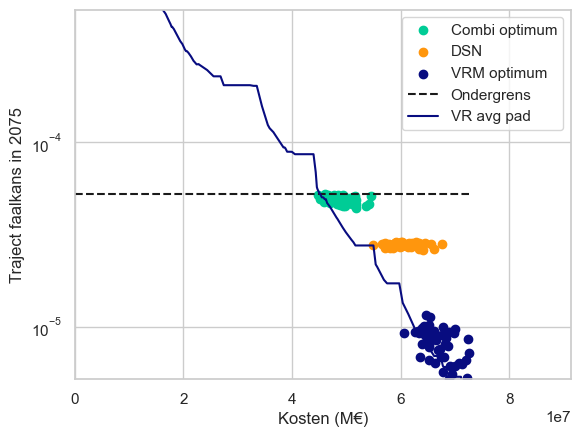

In [22]:
import matplotlib.pyplot as plt
def plot_sensitivity2(df_sensitivity: pd.DataFrame, path_vrm, pmax: float):
    fig, ax = plt.subplots()
    from scripts.design.deltares_colors import colors

    ax.scatter(df_sensitivity["least_expensive_combination_cost"], df_sensitivity["least_expensive_combination_pf"], color=colors[4], label='Combi optimum')
    ax.scatter(df_sensitivity["dsn_point_cost"], df_sensitivity["dsn_point_pf"], color=colors[6], label='DSN')
    ax.scatter(df_sensitivity["vrm_eco_point_cost"], df_sensitivity["vrm_eco_point_pf"], color=colors[0], label='VRM optimum')
    ax.hlines(pmax, 0, df_sensitivity['vrm_eco_point_cost'].max(), colors='k', linestyles='dashed', label='Ondergrens')
    ax.plot(path_vrm[:, 1], path_vrm[:, 0], color=colors[0], label='VR avg pad')
    ax.set_xlim(left=0)
    ax.set_xlabel('Kosten (M€)')
    ax.set_ylabel('Traject faalkans in 2075')
    ax.set_yscale('log')
    ax.set_ylim(top=pmax * 10, bottom=pmax / 10)
    ax.legend()

    plt.show()
pmax = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
plot_sensitivity2(df_results, path_vrm, pmax)